In [2]:
import torchvision.models as models
import torch
from torchvision import datasets
from data import data_transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import crop
import numpy as np
import torchvision.transforms as transforms
import os
import PIL.Image as Image




# Detector

In [3]:
# model = models.detection.retinanet_resnet50_fpn(pretrained=True)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

model.eval()
print('ok')


ok


# Utils

In [4]:
def make_square(pil_img, resize=224):
    w,h = pil_img.size
    if w>h:
        result = Image.new(pil_img.mode, (w, w))
        result.paste(pil_img, (0, (w-h)//2))
        return result.resize((224,224))
    else:
        result = Image.new(pil_img.mode, (h,h))
        result.paste(pil_img, ((h-w)//2, 0))
        return result.resize((224,224))


# Rest

In [5]:
my_trans = transforms.Compose(
    [
        # transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]
)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("bird_dataset/val_images", transform=my_trans),
    batch_size=10,
    shuffle=False,
    num_workers=1,
)


In [137]:
t = next(iter(val_loader))


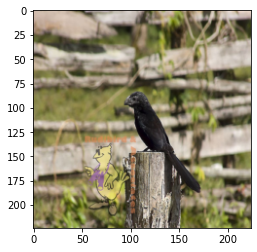

In [138]:
plt.imshow(t[0][0].permute(1,2,0))

model.eval()
detections = model(t[0])

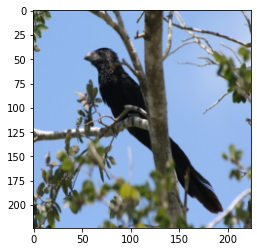

In [140]:
plt.imshow(t[0][1].permute(1,2,0))


(55, 73, 215, 195)

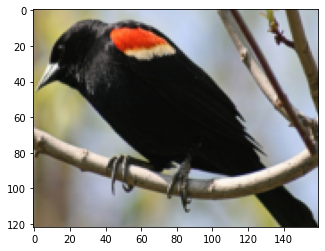

In [141]:
image=9

a,b,c,d=detections[image]["boxes"][0].detach().numpy().astype(int)

ret = crop(t[0][image],b,a,d-b,c-a )
plt.imshow(ret.permute(1,2,0))

a,b,c,d


In [6]:
def pil_load(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        with Image.open(f) as img:
            img = img.convert("RGB")
            return img

In [7]:
def crop_birds(detector, or_dir="bird_dataset/test_images/", tar_or_dir="bird_dataset2/test_images/"):
    detector.eval()
    wrong = []
    for dir in os.listdir(or_dir):
        if dir[0] != ".":
            test_dir = or_dir + dir
            print(test_dir)
            tar_dir = tar_or_dir + dir
            if not os.path.exists(tar_dir):
                os.makedirs(tar_dir)
            for f in os.listdir(test_dir):
                if "png" in f or "jpg" in f:
                    name = test_dir + "/" + f
                    img = pil_load(name)
                    data = my_trans(img)
                    output = detector(data[None, :])[0]

                    potential_birds = (output["labels"] == 16).nonzero(as_tuple=True)[0].detach().numpy()

                    if len(potential_birds)==0:
                        print("   uhoh",f)
                        wrong.append(test_dir + "/" + f)
                    else:
                        print("   ", f, "Score:", output["scores"][0] )
                        a,b,c,d=output["boxes"][potential_birds[0]].detach().numpy().astype(int)
                        ret = crop(img,b,a,d-b,c-a)
                        ret = make_square(ret)

                        ret.save(tar_dir+ "/" + f)
    return wrong
ret = crop_birds(model)

bird_dataset/test_images/mistery_category


/Users/nissim/anaconda3/envs/objrec/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


    f797dafedeabc2cd79aa730d029bd09b.jpg Score: tensor(0.9989, grad_fn=<SelectBackward0>)
    ebc9d3eac76dc9fcd450b312f1feace9.jpg Score: tensor(0.9970, grad_fn=<SelectBackward0>)
    20e309627aaf97e0fee50a39a434c2bf.jpg Score: tensor(0.9983, grad_fn=<SelectBackward0>)
    f530b89a6486d5cc8fe20cf1178ff150.jpg Score: tensor(0.9996, grad_fn=<SelectBackward0>)
    37abcbdb3bca852ee853c48fbd0f2d73.jpg Score: tensor(0.9920, grad_fn=<SelectBackward0>)
    47f6849caa9f6f62464a0c9a6e80d51f.jpg Score: tensor(0.9698, grad_fn=<SelectBackward0>)
    31e7782137785c3f93d141c4f1ae4a36.jpg Score: tensor(0.9943, grad_fn=<SelectBackward0>)
    bbe0a4e68ded4b91ac7f5b19d811e0ec.jpg Score: tensor(0.9992, grad_fn=<SelectBackward0>)
    c8ec34cf7ee54d51bb632a53d89f5c56.jpg Score: tensor(0.9772, grad_fn=<SelectBackward0>)
    90bf0ec139471e076020fc8aed9b2576.jpg Score: tensor(0.9930, grad_fn=<SelectBackward0>)
    d08b43687503170c36402386df6a490f.jpg Score: tensor(0.9870, grad_fn=<SelectBackward0>)
    90a9fb

In [8]:
ret

['bird_dataset/test_images/mistery_category/4836bedeec2a2617ee33922ebf89995a.jpg']

In [68]:
names=[
"d97a794bc6e951b13891873045115174",
"0676b04fc9527343bee8ae5a2a9d4692",
"0247efd7b9d47d036bb4390202a13e69",
"70fddb3c64b44a4d43e32a7c8148c425",
"64f3fa85502e9cff91d6dc88f54be7cb",
"035f7f6b1a162d86bb4755e6558f33d9",
"8ede0bc5a4976385dcfe6e38feaf90c2",
"4836bedeec2a2617ee33922ebf89995a"]

name = names[7]+".jpg"

In [69]:

img = pil_load("bird_dataset/test_images/mistery_category/"+name)
data = my_trans(img)
output = model(data[None, :])[0]
potential_birds = (output["labels"] == 16).nonzero(as_tuple=True)[0].detach().numpy()

# if len(potential_birds)==0:
#     print("   uhoh")
# else:

#     a,b,c,d=output["boxes"][potential_birds[0]].detach().numpy().astype(int)
#     ret = crop(img,b,a,d-b,c-a)
#     ret = make_square(ret)
#     # ret.save("bird_dataset2/"+name)

In [70]:
a,b,c,d=output["boxes"][potential_birds[0]].detach().numpy().astype(int)
ret = crop(img,b,a,d-b,c-a)
ret = make_square(ret)
ret

IndexError: index 0 is out of bounds for axis 0 with size 0

In [62]:
ret.save("bird_dataset2/"+name)